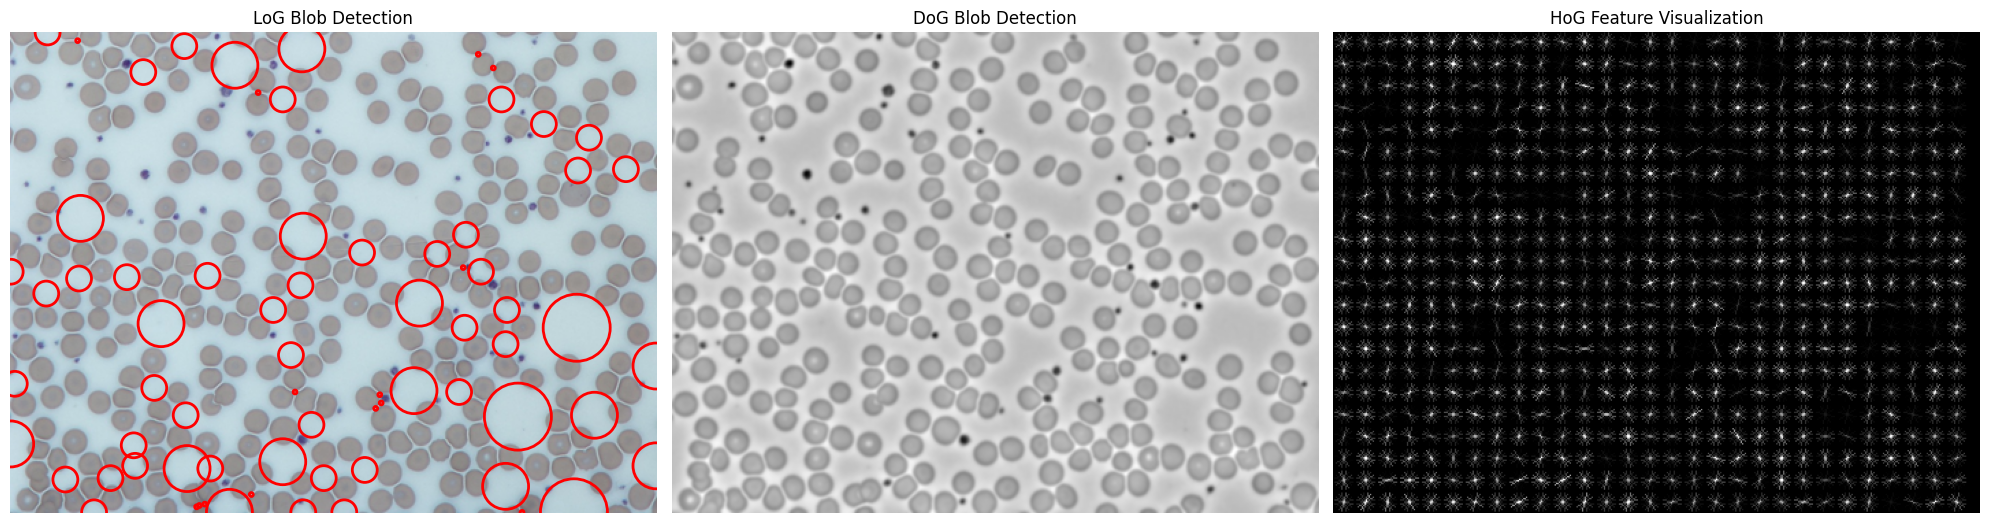

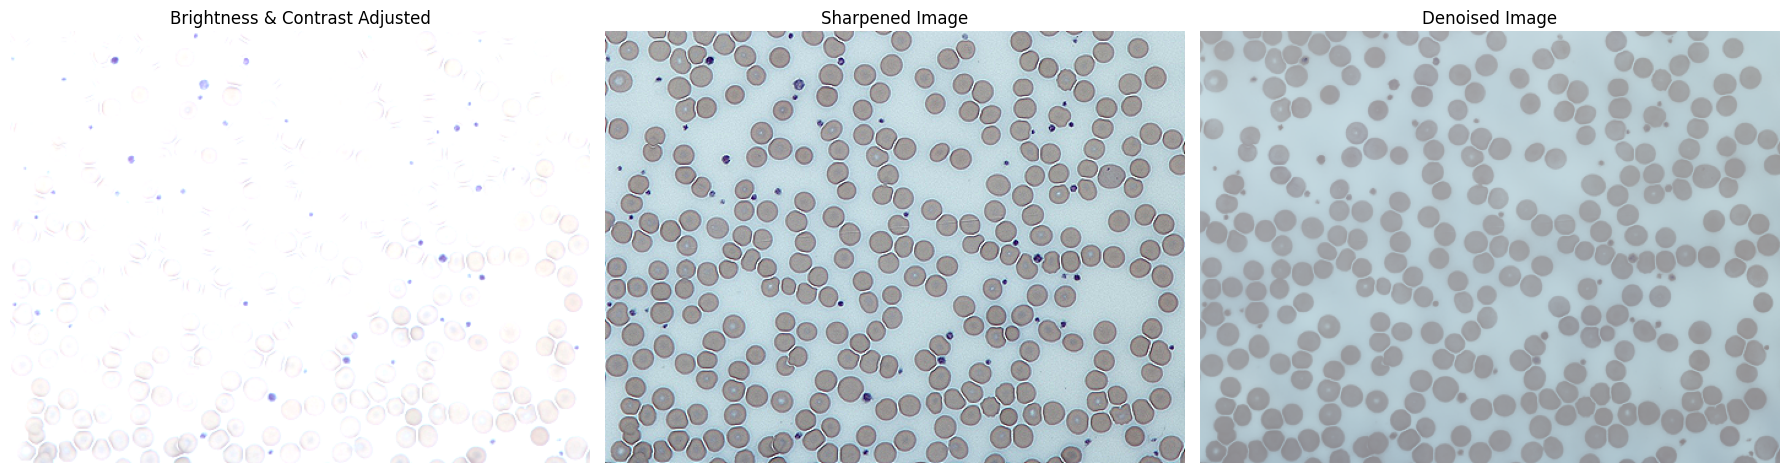

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.filters import difference_of_gaussians
from skimage.feature import hog
from skimage import exposure
from skimage.restoration import denoise_bilateral
from skimage.util import img_as_ubyte

image = cv2.imread('/content/image_2025-04-07_111254607.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blobs_log = blob_log(rgb2gray(image_rgb), min_sigma=1, max_sigma=50, num_sigma=10, threshold=0.1)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
dog_image = difference_of_gaussians(image_gray, low_sigma=1, high_sigma=5)

fd, hog_image = hog(image_gray,
                    orientations=8,
                    pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1),
                    visualize=True,
                    channel_axis=None)

hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].imshow(image_rgb)
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    axes[0].add_patch(c)
axes[0].set_title("LoG Blob Detection")
axes[0].axis('off')

axes[1].imshow(dog_image, cmap='gray')
axes[1].set_title("DoG Blob Detection")
axes[1].axis('off')

axes[2].imshow(hog_image, cmap='gray')
axes[2].set_title("HoG Feature Visualization")
axes[2].axis('off')

plt.tight_layout()
plt.show()

bright_contrast_img = cv2.convertScaleAbs(image, alpha=1.5, beta=30)

kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
sharpened_img = cv2.filter2D(image, -1, kernel)

denoised_img = denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15, channel_axis=-1)
denoised_img = img_as_ubyte(denoised_img)

fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))

axes2[0].imshow(cv2.cvtColor(bright_contrast_img, cv2.COLOR_BGR2RGB))
axes2[0].set_title("Brightness & Contrast Adjusted")
axes2[0].axis('off')

axes2[1].imshow(cv2.cvtColor(sharpened_img, cv2.COLOR_BGR2RGB))
axes2[1].set_title("Sharpened Image")
axes2[1].axis('off')

axes2[2].imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))
axes2[2].set_title("Denoised Image")
axes2[2].axis('off')

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.transform import warp
from skimage.filters import gaussian
from tensorflow.keras.datasets import mnist
import random


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

def elastic_transform(image, alpha, sigma):
    """Applies elastic deformation to an image."""
    image = np.squeeze(image)

    random_state = np.random.RandomState(None)
    shape = image.shape

    dx = gaussian(random_state.rand(*shape) * 2 - 1, sigma, mode="constant") * alpha
    dy = gaussian(random_state.rand(*shape) * 2 - 1, sigma, mode="constant") * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.array([y + dy, x + dx])

    return warp(image, indices, mode="reflect")

x_train_augmented = np.array([elastic_transform(img, alpha=5, sigma=1) for img in x_train])

x_train_augmented = np.expand_dims(x_train_augmented, axis=-1)

x_val, x_train = x_train[:5000], x_train[5000:]
y_val, y_train = y_train[:5000], y_train[5000:]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [2]:
def sample_few_shot_data(x_data, y_data, num_classes=10, num_samples=5):
    support_set = []
    query_set = []

    for cls in range(num_classes):
        indices = np.where(y_data == cls)[0]
        selected = np.random.choice(indices, num_samples + 1, replace=False)
        support_set.append(x_data[selected[:num_samples]])
        query_set.append(x_data[selected[num_samples]])

    return np.array(support_set), np.array(query_set)

x_support_set, x_query_set = sample_few_shot_data(x_train, y_train, num_classes=10, num_samples=5)

In [3]:
def build_prototypical_network(input_shape=(28, 28, 1)):
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

prototypical_model = build_prototypical_network()
prototypical_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

def build_siamese_network(input_shape=(28, 28, 1)):
    input1 = keras.Input(shape=input_shape)
    input2 = keras.Input(shape=input_shape)

    base_model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu")
    ])

    encoded1 = base_model(input1)
    encoded2 = base_model(input2)

    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([encoded1, encoded2])
    output = layers.Dense(1, activation="sigmoid")(distance)

    model = keras.Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

siamese_model = build_siamese_network()

print("x_support_set shape before reshape:", x_support_set.shape)
print("x_query_set shape before reshape:", x_query_set.shape)

num_samples = min(len(x_support_set), len(x_query_set))

expected_size = num_samples * 28 * 28
actual_size_support = x_support_set[:num_samples].size
actual_size_query = x_query_set[:num_samples].size

if actual_size_support == expected_size and actual_size_query == expected_size:
    x_support_set = x_support_set[:num_samples].reshape(num_samples, 28, 28, 1)
    x_query_set = x_query_set[:num_samples].reshape(num_samples, 28, 28, 1)
else:
    print(f"Reshape Error: Expected {expected_size} elements but got {actual_size_support} & {actual_size_query}")

if x_support_set.shape == (num_samples, 28, 28, 1) and x_query_set.shape == (num_samples, 28, 28, 1):
    siamese_model.fit([x_support_set, x_query_set], np.ones((num_samples, 1)), epochs=10)
else:
    print("Skipping training due to incorrect shapes")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9121 - loss: 0.2722 - val_accuracy: 0.9890 - val_loss: 0.0438
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9873 - loss: 0.0387 - val_accuracy: 0.9874 - val_loss: 0.0401
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9918 - loss: 0.0282 - val_accuracy: 0.9910 - val_loss: 0.0346
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9943 - loss: 0.0192 - val_accuracy: 0.9916 - val_loss: 0.0308
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9959 - loss: 0.0124 - val_accuracy: 0.9896 - val_loss: 0.0331
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9970 - loss: 0.0098 - val_accuracy: 0.9910 - val_loss: 0.0351
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9976 - loss: 0.0069 - val_accuracy: 0.9926 - val_loss: 0.0310
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9978 - loss: 0.006

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Dummy Data Preparation (Replace with your actual data!)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, -1)  # (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)    # (10000, 28, 28, 1)

# Split validation set
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

# For Siamese network: prepare support and query sets (dummy for now)
x_support_set = x_train[:100]
x_query_set = x_train[100:200]
y_siamese = np.random.randint(0, 2, size=(100, 1))  # binary labels

# -----------------------------
# 1. Prototypical Network
# -----------------------------
def build_prototypical_network(input_shape=(28, 28, 1)):
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

prototypical_model = build_prototypical_network()
prototypical_model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

# -----------------------------
# 2. Siamese Network
# -----------------------------
def build_siamese_network(input_shape=(28, 28, 1)):
    input1 = keras.Input(shape=input_shape)
    input2 = keras.Input(shape=input_shape)

    base_model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu")
    ])

    encoded1 = base_model(input1)
    encoded2 = base_model(input2)

    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([encoded1, encoded2])
    output = layers.Dense(1, activation="sigmoid")(distance)

    model = keras.Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

siamese_model = build_siamese_network()
siamese_model.fit([x_support_set, x_query_set], y_siamese, epochs=5, batch_size=16)

# -----------------------------
# 3. Matching Network
# -----------------------------
def build_matching_network(input_shape=(28, 28, 1)):
    input_img = keras.Input(shape=input_shape)

    base_model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu")
    ])

    encoded = base_model(input_img)
    output = layers.Dense(10, activation="softmax")(encoded)

    model = keras.Model(inputs=input_img, outputs=output)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

matching_network = build_matching_network()
matching_network.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

# -----------------------------
# 4. Evaluation
# -----------------------------

print("\nEvaluating Models...\n")

# Prototypical Network
proto_loss, proto_acc = prototypical_model.evaluate(x_test, y_test, verbose=0)

# Siamese Network — create test set properly
x_support_test = x_test[:100]
x_query_test = x_test[100:200]
y_siamese_test = np.random.randint(0, 2, size=(100, 1))

siamese_loss, siamese_acc = siamese_model.evaluate([x_support_test, x_query_test], y_siamese_test, verbose=0)

# Matching Network
matching_loss, matching_acc = matching_network.evaluate(x_test, y_test, verbose=0)

print(f"Prototypical Network Accuracy: {proto_acc * 100:.2f}%")
print(f"Siamese Network Accuracy: {siamese_acc * 100:.2f}%")
print(f"Matching Network Accuracy: {matching_acc * 100:.2f}%")


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9095 - loss: 0.2890 - val_accuracy: 0.9846 - val_loss: 0.0523
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9863 - loss: 0.0440 - val_accuracy: 0.9898 - val_loss: 0.0339
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9904 - loss: 0.0292 - val_accuracy: 0.9897 - val_loss: 0.0340
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9947 - loss: 0.0176 - val_accuracy: 0.9895 - val_loss: 0.0368
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9960 - loss: 0.0123 - val_accuracy: 0.9897 - val_loss: 0.0386
Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.4733 - loss: 0.6960
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7108 - loss: 0.6342 
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7705 - loss: 0.5442 
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8116 - loss: 0.5120 
Epoch 5/5
7/7 ━━━━━━━━━━